In [5]:
# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Flatten, Conv1D, MaxPooling1D
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, EarlyStopping, Callback
from keras import optimizers
from keras.initializers import Orthogonal as orth

import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.io as sio


nb_filters = 30
kernel_size = 40
dense1_n = 10
epochs = 1000

patience = 30

steps = np.arange(0.1, 0.6, 0.1)
reps = range(7)

acc = np.zeros((len(steps),len(reps)))

for j in range(len(steps)):
    for k in reps:
    
        print('Current test/train split is', steps[j], '/', 1-steps[j])
        print('Repetition', k, 'out of', max(reps))

        t0 = time.time()

        # load data from the .mat file:
        mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/KOS_100Hz_ICA->0.5-38Hz,Env=1.mat')

        X = mat_contents['X']
        Y = mat_contents['Z'].T

        winsize = mat_contents['winsize']
        stepsize = mat_contents['stepsize']
        trial_len = mat_contents['trial_len']
        low_cutoff = mat_contents['low_cutoff']
        high_cutoff = mat_contents['high_cutoff']
        source = mat_contents['filein']

        # verify that the model REALLY finds a mapping between the input and the labels. If we get
        # our accuracy by chance, then we should get the same accuracy on a permuted dataset:
        # Y = np.random.permutation(Y)

        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=steps[j])
        print('Original data type:', x_train.dtype)

        # convert to float64 for numerical stability:
        x_train = x_train.astype('float64')
        y_train = y_train.astype('float64')
        x_test = x_test.astype('float64')
        y_test = y_test.astype('float64')

        # normalize to unit variance and zero mean:
        for i in range(x_train.shape[0]):
            x_train[i,:,:] = preprocessing.scale(x_train[i,:,:], axis=1)
            x_train[i,:,:] = preprocessing.minmax_scale(x_train[i,:,:], axis=1)

        for i in range(x_test.shape[0]):
            x_test[i,:,:] = preprocessing.scale(x_test[i,:,:], axis=1)
            x_test[i,:,:] = preprocessing.minmax_scale(x_test[i,:,:], axis=1)

        # ensure the tensors are sized right:
        x_train = np.transpose(x_train,(0,2,1))
        x_test = np.transpose(x_test,(0,2,1))

        # one hot encode the labels:
        onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
        y_train = onehot_encoder.fit_transform(y_train)
        y_test = onehot_encoder.fit_transform(y_test)

        # convert to float16 to save space:
        x_train = x_train.astype('float16')
        y_train = y_train.astype('float16')
        x_test = x_test.astype('float16')
        y_test = y_test.astype('float16')
        print('Normalized data type:', x_train.dtype)

        print('test input shape', x_test.shape, "Nomralized MEAN:", np.mean(x_test), "min", np.min(x_test),"max", np.max(x_test))
        print('train input shape', x_train.shape, "Nomralized MEAN:", np.mean(x_train), "min", np.min(x_train),"max", np.max(x_train))

        print('test labels shape', y_test.shape, "Nomralized MEAN:", np.mean(y_test), "min", np.min(y_test),"max", np.max(y_test))
        print('train labels shape', y_train.shape, "Nomralized MEAN:", np.mean(y_train), "min", np.min(y_train),"max", np.max(y_train))

        print('Window length', winsize)
        print('Step size:', stepsize)
        print('Length of trial during experiment', trial_len)
        print('Low cutoff freq.', low_cutoff)
        print('High cutoff freq.', high_cutoff)
        print('Source data file:', source)

        leng = x_test.shape[1]

        def Encoder():

            input_img = Input(shape=(leng, 60))
            inputbn = BatchNormalization(axis = 1)(input_img) ###########################################why this axis?

            convolved = Conv1D(nb_filters, kernel_size, padding="same", activation='relu',
                              kernel_initializer = orth(gain=1.0, seed=None))(inputbn)
            dropout1 = Dropout(0.1)(convolved)
            convolvedbn = BatchNormalization()(dropout1)
            pooled = MaxPooling1D()(convolvedbn)

            convolved2 = Conv1D(nb_filters*2, kernel_size, padding="same", activation='relu',
                               kernel_initializer = orth(gain=1.0, seed=None))(pooled)
            dropout2 = Dropout(0.2)(convolved2)
            convolved2bn = BatchNormalization()(dropout2)
            pooled2 = MaxPooling1D()(convolved2bn)

            convolved3 = Conv1D(nb_filters*4, kernel_size, padding="same", activation='relu',
                               kernel_initializer = orth(gain=1.0, seed=None))(pooled2)
            dropout3 = Dropout(0.3)(convolved3)
            convolved3bn = BatchNormalization()(dropout3)
            pooled3 = MaxPooling1D()(convolved3bn)

            flat = Flatten()(pooled3)

            dense1 = Dense(dense1_n, activation='relu')(flat)
            dense1bn = BatchNormalization()(dense1)
            dense1do = Dropout(0.5)(dense1bn)

            out = Dense(2, activation='softmax')(dense1do)

            return Model(input_img, out)


        enc = Encoder()
        enc.compile(loss="binary_crossentropy", optimizer="adadelta", metrics=["accuracy"])

        # enc.summary()
        ##########################################################

        # Training time!
        from keras.callbacks import TensorBoard, EarlyStopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')

        train_history = enc.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=40,
                        shuffle=True,
                        validation_data=(x_test, y_test),
                        callbacks=[TensorBoard(log_dir='/home/amplifier/home/CNN_stim'), early_stopping])

        ###########################################################

        # let's predict a TRAINING sammple:
        decoded_train = enc.predict(x_train)
        decoded_test = enc.predict(x_test)
        #####################################################

        # now test sample by sample
        cor_test = []
        L = x_test.shape
        for sample_no in range(x_test.shape[0]):
            pred = enc.predict(np.expand_dims(x_test[sample_no],0))
            if ((pred[0][0]<pred[0][1]) and (y_test[sample_no,0] < y_test[sample_no,1]) or
               ((pred[0][0]>pred[0][1]) & (y_test[sample_no,0] > y_test[sample_no,1]))):
                cor_test.append(1)
            else:
                cor_test.append(0)

        cor_train = []
        L = x_train.shape
        for sample_no in range(x_train.shape[0]):
            pred = enc.predict(np.expand_dims(x_train[sample_no],0))
            if ((pred[0][0]<pred[0][1]) and (y_train[sample_no,0] < y_train[sample_no,1]) or
               ((pred[0][0]>pred[0][1]) & (y_train[sample_no,0] > y_train[sample_no,1]))):
                cor_train.append(1)
            else:
                cor_train.append(0)

        # Report accuracies
#         print('Accuracy on the test data:', np.mean(cor_test))
#         print('Accuracy on the training data:', np.mean(cor_train))
        t1 = time.time()
        print('Elapsed', t1-t0, 'seconds')

        acc[j,k] = np.mean(cor_test)

Current test/train split is 0.1 / 0.9
Repetition 0 out of 6
Original data type: float32
Normalized data type: float16
test input shape (81, 400, 60) Nomralized MEAN: 0.5083 min 0.0 max 1.0
train input shape (725, 400, 60) Nomralized MEAN: 0.5083 min 0.0 max 1.0
test labels shape (81, 2) Nomralized MEAN: 0.5 min 0.0 max 1.0
train labels shape (725, 2) Nomralized MEAN: 0.5 min 0.0 max 1.0
Window length [[5]]
Step size: [[1]]
Length of trial during experiment [[30]]
Low cutoff freq. [[ 0.5]]
High cutoff freq. [[38]]
Source data file: ['KOS_100Hz_ICA']
Train on 725 samples, validate on 81 samples
Epoch 1/1000
725/725 [==============================] - 1s 1ms/step - loss: 0.9488 - acc: 0.4924 - val_loss: 0.6813 - val_acc: 0.6543
Epoch 2/1000
725/725 [==============================] - 0s 656us/step - loss: 0.6854 - acc: 0.6317 - val_loss: 0.7617 - val_acc: 0.6049
Epoch 3/1000
725/725 [==============================] - 1s 707us/step - loss: 0.6081 - acc: 0.6897 - val_loss: 0.7905 - val_acc: 0

725/725 [==============================] - 1s 714us/step - loss: 0.0145 - acc: 0.9972 - val_loss: 0.0437 - val_acc: 0.9753
Epoch 57/1000
725/725 [==============================] - 1s 734us/step - loss: 0.0100 - acc: 0.9972 - val_loss: 0.0418 - val_acc: 0.9877
Epoch 58/1000
725/725 [==============================] - 1s 712us/step - loss: 0.0079 - acc: 1.0000 - val_loss: 0.0255 - val_acc: 1.0000
Epoch 59/1000
725/725 [==============================] - 1s 729us/step - loss: 0.0095 - acc: 0.9959 - val_loss: 0.0228 - val_acc: 1.0000
Epoch 60/1000
725/725 [==============================] - 1s 696us/step - loss: 0.0379 - acc: 0.9931 - val_loss: 0.0687 - val_acc: 0.9630
Epoch 61/1000
725/725 [==============================] - 1s 714us/step - loss: 0.0252 - acc: 0.9903 - val_loss: 0.0652 - val_acc: 0.9630
Epoch 62/1000
725/725 [==============================] - 1s 723us/step - loss: 0.0334 - acc: 0.9917 - val_loss: 0.1236 - val_acc: 0.9630
Epoch 63/1000
725/725 [==============================] 

725/725 [==============================] - 1s 2ms/step - loss: 1.1873 - acc: 0.5297 - val_loss: 5.0318 - val_acc: 0.5556
Epoch 2/1000
725/725 [==============================] - 1s 721us/step - loss: 0.8664 - acc: 0.5559 - val_loss: 1.1696 - val_acc: 0.4444
Epoch 3/1000
725/725 [==============================] - 1s 728us/step - loss: 0.6963 - acc: 0.6731 - val_loss: 1.1547 - val_acc: 0.4568
Epoch 4/1000
725/725 [==============================] - 1s 739us/step - loss: 0.5803 - acc: 0.7255 - val_loss: 0.9115 - val_acc: 0.5185
Epoch 5/1000
725/725 [==============================] - 1s 732us/step - loss: 0.4651 - acc: 0.8055 - val_loss: 0.9733 - val_acc: 0.4938
Epoch 6/1000
725/725 [==============================] - 1s 701us/step - loss: 0.5191 - acc: 0.7779 - val_loss: 0.5193 - val_acc: 0.7778
Epoch 7/1000
725/725 [==============================] - 1s 739us/step - loss: 0.3763 - acc: 0.8524 - val_loss: 0.5792 - val_acc: 0.6790
Epoch 8/1000
725/725 [==============================] - 1s 722u

Epoch 61/1000
725/725 [==============================] - 1s 729us/step - loss: 0.0073 - acc: 1.0000 - val_loss: 0.0472 - val_acc: 0.9877
Epoch 62/1000
725/725 [==============================] - 1s 695us/step - loss: 0.0059 - acc: 0.9986 - val_loss: 0.0540 - val_acc: 0.9877
Epoch 63/1000
725/725 [==============================] - 1s 713us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0544 - val_acc: 0.9877
Epoch 64/1000
725/725 [==============================] - 1s 713us/step - loss: 0.0060 - acc: 0.9986 - val_loss: 0.0778 - val_acc: 0.9753
Epoch 65/1000
725/725 [==============================] - 1s 706us/step - loss: 0.0072 - acc: 0.9972 - val_loss: 0.1883 - val_acc: 0.9506
Epoch 66/1000
725/725 [==============================] - 1s 700us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.1123 - val_acc: 0.9753
Epoch 67/1000
725/725 [==============================] - 1s 713us/step - loss: 0.0061 - acc: 0.9959 - val_loss: 0.1039 - val_acc: 0.9877
Epoch 68/1000
725/725 [==================

725/725 [==============================] - 1s 720us/step - loss: 0.0205 - acc: 0.9972 - val_loss: 0.0610 - val_acc: 0.9877
Epoch 28/1000
725/725 [==============================] - 0s 686us/step - loss: 0.0550 - acc: 0.9903 - val_loss: 0.1942 - val_acc: 0.9383
Epoch 29/1000
725/725 [==============================] - 1s 733us/step - loss: 0.0298 - acc: 0.9903 - val_loss: 0.1432 - val_acc: 0.9506
Epoch 30/1000
725/725 [==============================] - 1s 718us/step - loss: 0.0208 - acc: 0.9972 - val_loss: 0.1754 - val_acc: 0.9383
Epoch 31/1000
725/725 [==============================] - 1s 696us/step - loss: 0.0148 - acc: 1.0000 - val_loss: 0.1669 - val_acc: 0.9383
Epoch 32/1000
725/725 [==============================] - 0s 687us/step - loss: 0.0212 - acc: 0.9959 - val_loss: 0.1256 - val_acc: 0.9383
Epoch 33/1000
725/725 [==============================] - 1s 753us/step - loss: 0.0194 - acc: 0.9945 - val_loss: 0.1285 - val_acc: 0.9630
Epoch 34/1000
725/725 [==============================] 

725/725 [==============================] - 1s 704us/step - loss: 0.0522 - acc: 0.9959 - val_loss: 0.1817 - val_acc: 0.9136
Epoch 26/1000
725/725 [==============================] - 1s 702us/step - loss: 0.0369 - acc: 0.9931 - val_loss: 0.4137 - val_acc: 0.8642
Epoch 27/1000
725/725 [==============================] - 1s 723us/step - loss: 0.0386 - acc: 0.9945 - val_loss: 0.2115 - val_acc: 0.9136
Epoch 28/1000
725/725 [==============================] - 1s 712us/step - loss: 0.0319 - acc: 1.0000 - val_loss: 0.1687 - val_acc: 0.9136
Epoch 29/1000
725/725 [==============================] - 1s 741us/step - loss: 0.0366 - acc: 0.9959 - val_loss: 0.1603 - val_acc: 0.9136
Epoch 30/1000
725/725 [==============================] - 1s 704us/step - loss: 0.0334 - acc: 0.9986 - val_loss: 0.1133 - val_acc: 0.9506
Epoch 31/1000
725/725 [==============================] - 1s 735us/step - loss: 0.0276 - acc: 0.9959 - val_loss: 0.1760 - val_acc: 0.9383
Epoch 32/1000
725/725 [==============================] 

725/725 [==============================] - 0s 670us/step - loss: 0.8925 - acc: 0.5986 - val_loss: 0.9661 - val_acc: 0.5432
Epoch 3/1000
725/725 [==============================] - 1s 725us/step - loss: 0.8232 - acc: 0.6055 - val_loss: 0.7095 - val_acc: 0.6173
Epoch 4/1000
725/725 [==============================] - 1s 692us/step - loss: 0.5846 - acc: 0.7090 - val_loss: 0.5795 - val_acc: 0.6790
Epoch 5/1000
725/725 [==============================] - 1s 734us/step - loss: 0.5514 - acc: 0.7393 - val_loss: 0.7902 - val_acc: 0.5926
Epoch 6/1000
725/725 [==============================] - 1s 722us/step - loss: 0.4867 - acc: 0.7793 - val_loss: 0.6056 - val_acc: 0.7407
Epoch 7/1000
725/725 [==============================] - 1s 721us/step - loss: 0.4182 - acc: 0.8110 - val_loss: 0.4706 - val_acc: 0.7654
Epoch 8/1000
725/725 [==============================] - 1s 716us/step - loss: 0.3585 - acc: 0.8538 - val_loss: 0.5315 - val_acc: 0.6914
Epoch 9/1000
725/725 [==============================] - 1s 73

Epoch 62/1000
725/725 [==============================] - 1s 717us/step - loss: 0.0174 - acc: 0.9945 - val_loss: 0.8039 - val_acc: 0.8025
Epoch 63/1000
725/725 [==============================] - 1s 713us/step - loss: 0.0293 - acc: 0.9890 - val_loss: 0.4441 - val_acc: 0.8642
Epoch 64/1000
725/725 [==============================] - 0s 687us/step - loss: 0.0261 - acc: 0.9890 - val_loss: 0.3261 - val_acc: 0.9012
Epoch 65/1000
725/725 [==============================] - 1s 723us/step - loss: 0.0212 - acc: 0.9931 - val_loss: 0.3988 - val_acc: 0.9136
Epoch 66/1000
725/725 [==============================] - 1s 719us/step - loss: 0.0148 - acc: 0.9959 - val_loss: 0.4057 - val_acc: 0.9012
Epoch 67/1000
725/725 [==============================] - 0s 683us/step - loss: 0.0249 - acc: 0.9931 - val_loss: 0.3575 - val_acc: 0.9136
Epoch 68/1000
725/725 [==============================] - 1s 706us/step - loss: 0.0080 - acc: 1.0000 - val_loss: 0.3113 - val_acc: 0.9136
Epoch 69/1000
725/725 [==================

725/725 [==============================] - 1s 719us/step - loss: 0.0208 - acc: 1.0000 - val_loss: 0.1954 - val_acc: 0.9259
Epoch 29/1000
725/725 [==============================] - 1s 729us/step - loss: 0.0289 - acc: 0.9959 - val_loss: 0.1320 - val_acc: 0.9383
Epoch 30/1000
725/725 [==============================] - 1s 708us/step - loss: 0.0207 - acc: 0.9986 - val_loss: 0.1150 - val_acc: 0.9506
Epoch 31/1000
725/725 [==============================] - 1s 715us/step - loss: 0.0207 - acc: 0.9959 - val_loss: 0.0810 - val_acc: 0.9753
Epoch 32/1000
725/725 [==============================] - 1s 715us/step - loss: 0.0241 - acc: 0.9931 - val_loss: 0.0510 - val_acc: 0.9877
Epoch 33/1000
725/725 [==============================] - 1s 739us/step - loss: 0.0188 - acc: 0.9986 - val_loss: 0.0508 - val_acc: 0.9877
Epoch 34/1000
725/725 [==============================] - 1s 730us/step - loss: 0.0125 - acc: 0.9986 - val_loss: 0.0376 - val_acc: 0.9877
Epoch 35/1000
725/725 [==============================] 

Epoch 88/1000
725/725 [==============================] - 1s 720us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0223 - val_acc: 0.9877
Epoch 89/1000
725/725 [==============================] - 1s 743us/step - loss: 0.0058 - acc: 0.9986 - val_loss: 0.0282 - val_acc: 0.9877
Epoch 90/1000
725/725 [==============================] - 1s 710us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0378 - val_acc: 0.9877
Epoch 91/1000
725/725 [==============================] - 1s 712us/step - loss: 0.0169 - acc: 0.9972 - val_loss: 0.0254 - val_acc: 0.9877
Epoch 92/1000
725/725 [==============================] - 1s 737us/step - loss: 0.0036 - acc: 0.9986 - val_loss: 0.0183 - val_acc: 0.9877
Epoch 93/1000
725/725 [==============================] - 1s 734us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0285 - val_acc: 0.9877
Epoch 94/1000
725/725 [==============================] - 1s 720us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.0130 - val_acc: 1.0000
Epoch 95/1000
725/725 [==================

725/725 [==============================] - 1s 703us/step - loss: 0.0849 - acc: 0.9766 - val_loss: 0.3566 - val_acc: 0.8519
Epoch 18/1000
725/725 [==============================] - 1s 717us/step - loss: 0.0789 - acc: 0.9876 - val_loss: 0.1342 - val_acc: 0.9630
Epoch 19/1000
725/725 [==============================] - 1s 732us/step - loss: 0.0604 - acc: 0.9848 - val_loss: 0.3975 - val_acc: 0.8148
Epoch 20/1000
725/725 [==============================] - 1s 731us/step - loss: 0.0743 - acc: 0.9779 - val_loss: 0.3173 - val_acc: 0.8519
Epoch 21/1000
725/725 [==============================] - 1s 725us/step - loss: 0.0550 - acc: 0.9862 - val_loss: 0.1269 - val_acc: 0.9506
Epoch 22/1000
725/725 [==============================] - 1s 732us/step - loss: 0.0376 - acc: 0.9959 - val_loss: 0.1591 - val_acc: 0.9383
Epoch 23/1000
725/725 [==============================] - 1s 709us/step - loss: 0.0411 - acc: 0.9945 - val_loss: 0.1374 - val_acc: 0.9259
Epoch 24/1000
725/725 [==============================] 

Epoch 77/1000
725/725 [==============================] - 1s 721us/step - loss: 0.0072 - acc: 0.9986 - val_loss: 0.1178 - val_acc: 0.9630
Epoch 78/1000
725/725 [==============================] - 1s 705us/step - loss: 0.0086 - acc: 0.9959 - val_loss: 0.0408 - val_acc: 0.9877
Epoch 79/1000
725/725 [==============================] - 1s 741us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0402 - val_acc: 0.9753
Epoch 80/1000
725/725 [==============================] - 1s 727us/step - loss: 0.0177 - acc: 0.9945 - val_loss: 0.0553 - val_acc: 0.9753
Epoch 81/1000
725/725 [==============================] - 1s 708us/step - loss: 0.0095 - acc: 0.9986 - val_loss: 0.0637 - val_acc: 0.9753
Epoch 82/1000
725/725 [==============================] - 1s 738us/step - loss: 0.0084 - acc: 1.0000 - val_loss: 0.0649 - val_acc: 0.9753
Epoch 83/1000
725/725 [==============================] - 1s 720us/step - loss: 0.0136 - acc: 0.9917 - val_loss: 0.0806 - val_acc: 0.9630
Epoch 84/1000
725/725 [==================

644/644 [==============================] - 0s 769us/step - loss: 0.0428 - acc: 0.9938 - val_loss: 0.4154 - val_acc: 0.8457
Epoch 39/1000
644/644 [==============================] - 0s 768us/step - loss: 0.0334 - acc: 0.9938 - val_loss: 0.1810 - val_acc: 0.9321
Epoch 40/1000
644/644 [==============================] - 1s 782us/step - loss: 0.0239 - acc: 0.9969 - val_loss: 0.2148 - val_acc: 0.9074
Epoch 41/1000
644/644 [==============================] - 1s 780us/step - loss: 0.0227 - acc: 1.0000 - val_loss: 0.1883 - val_acc: 0.9259
Epoch 42/1000
644/644 [==============================] - 0s 767us/step - loss: 0.0248 - acc: 0.9984 - val_loss: 0.1766 - val_acc: 0.9321
Epoch 43/1000
644/644 [==============================] - 1s 798us/step - loss: 0.0179 - acc: 0.9984 - val_loss: 0.1438 - val_acc: 0.9444
Epoch 44/1000
644/644 [==============================] - 1s 788us/step - loss: 0.0204 - acc: 0.9984 - val_loss: 0.3037 - val_acc: 0.8580
Epoch 45/1000
644/644 [==============================] 

Train on 644 samples, validate on 162 samples
Epoch 1/1000
644/644 [==============================] - 1s 2ms/step - loss: 1.2572 - acc: 0.5047 - val_loss: 2.6987 - val_acc: 0.4938
Epoch 2/1000
644/644 [==============================] - 0s 727us/step - loss: 0.8322 - acc: 0.6102 - val_loss: 0.7368 - val_acc: 0.6173
Epoch 3/1000
644/644 [==============================] - 0s 765us/step - loss: 0.8271 - acc: 0.6677 - val_loss: 0.9102 - val_acc: 0.5802
Epoch 4/1000
644/644 [==============================] - 0s 730us/step - loss: 0.7535 - acc: 0.6553 - val_loss: 0.6328 - val_acc: 0.6543
Epoch 5/1000
644/644 [==============================] - 1s 787us/step - loss: 0.6344 - acc: 0.6879 - val_loss: 0.5653 - val_acc: 0.6914
Epoch 6/1000
644/644 [==============================] - 1s 801us/step - loss: 0.5362 - acc: 0.7143 - val_loss: 0.5769 - val_acc: 0.7284
Epoch 7/1000
644/644 [==============================] - 0s 767us/step - loss: 0.5233 - acc: 0.7578 - val_loss: 0.5903 - val_acc: 0.6852
Epoc

644/644 [==============================] - 1s 784us/step - loss: 0.0125 - acc: 0.9984 - val_loss: 0.1154 - val_acc: 0.9568
Epoch 61/1000
644/644 [==============================] - 0s 769us/step - loss: 0.0107 - acc: 1.0000 - val_loss: 0.1097 - val_acc: 0.9568
Epoch 62/1000
644/644 [==============================] - 0s 762us/step - loss: 0.0100 - acc: 1.0000 - val_loss: 0.0965 - val_acc: 0.9691
Epoch 63/1000
644/644 [==============================] - 0s 761us/step - loss: 0.0079 - acc: 1.0000 - val_loss: 0.0787 - val_acc: 0.9753
Epoch 64/1000
644/644 [==============================] - 1s 786us/step - loss: 0.0121 - acc: 0.9984 - val_loss: 0.0771 - val_acc: 0.9753
Epoch 65/1000
644/644 [==============================] - 0s 750us/step - loss: 0.0169 - acc: 0.9984 - val_loss: 0.4405 - val_acc: 0.8765
Epoch 66/1000
644/644 [==============================] - 1s 777us/step - loss: 0.0736 - acc: 0.9845 - val_loss: 0.5570 - val_acc: 0.8395
Epoch 67/1000
644/644 [==============================] 

Epoch 120/1000
644/644 [==============================] - 1s 791us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0501 - val_acc: 0.9877
Epoch 121/1000
644/644 [==============================] - 1s 790us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0434 - val_acc: 0.9877
Epoch 122/1000
644/644 [==============================] - 1s 792us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.0584 - val_acc: 0.9753
Epoch 123/1000
644/644 [==============================] - 1s 792us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.0434 - val_acc: 0.9753
Epoch 124/1000
644/644 [==============================] - 1s 781us/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0301 - val_acc: 1.0000
Epoch 125/1000
644/644 [==============================] - 0s 768us/step - loss: 0.0223 - acc: 0.9984 - val_loss: 0.0716 - val_acc: 0.9753
Epoch 126/1000
644/644 [==============================] - 1s 777us/step - loss: 0.0067 - acc: 1.0000 - val_loss: 0.0527 - val_acc: 0.9815
Epoch 127/1000
644/644 [==========

Epoch 5/1000
644/644 [==============================] - 1s 785us/step - loss: 0.5047 - acc: 0.7252 - val_loss: 0.6101 - val_acc: 0.6420
Epoch 6/1000
644/644 [==============================] - 1s 791us/step - loss: 0.4443 - acc: 0.8059 - val_loss: 0.6358 - val_acc: 0.6420
Epoch 7/1000
644/644 [==============================] - 0s 774us/step - loss: 0.4143 - acc: 0.8276 - val_loss: 0.7443 - val_acc: 0.5926
Epoch 8/1000
644/644 [==============================] - 1s 788us/step - loss: 0.4425 - acc: 0.7935 - val_loss: 0.6424 - val_acc: 0.6235
Epoch 9/1000
644/644 [==============================] - 1s 788us/step - loss: 0.3608 - acc: 0.8463 - val_loss: 0.6108 - val_acc: 0.6975
Epoch 10/1000
644/644 [==============================] - 0s 764us/step - loss: 0.3078 - acc: 0.8882 - val_loss: 0.5874 - val_acc: 0.6728
Epoch 11/1000
644/644 [==============================] - 0s 754us/step - loss: 0.2751 - acc: 0.9022 - val_loss: 0.6204 - val_acc: 0.7284
Epoch 12/1000
644/644 [=======================

Epoch 65/1000
644/644 [==============================] - 1s 788us/step - loss: 0.0104 - acc: 0.9984 - val_loss: 0.2292 - val_acc: 0.8951
Epoch 66/1000
644/644 [==============================] - 0s 760us/step - loss: 0.0225 - acc: 0.9984 - val_loss: 0.1484 - val_acc: 0.9444
Epoch 67/1000
644/644 [==============================] - 0s 776us/step - loss: 0.0181 - acc: 0.9969 - val_loss: 0.1691 - val_acc: 0.9321
Epoch 68/1000
644/644 [==============================] - 1s 790us/step - loss: 0.0181 - acc: 0.9922 - val_loss: 0.5300 - val_acc: 0.8395
Epoch 69/1000
644/644 [==============================] - 1s 796us/step - loss: 0.0352 - acc: 0.9938 - val_loss: 0.2029 - val_acc: 0.9444
Epoch 70/1000
644/644 [==============================] - 0s 767us/step - loss: 0.0381 - acc: 0.9845 - val_loss: 0.2458 - val_acc: 0.9198
Epoch 71/1000
644/644 [==============================] - 1s 792us/step - loss: 0.0249 - acc: 0.9938 - val_loss: 0.1995 - val_acc: 0.9383
Epoch 72/1000
644/644 [==================

644/644 [==============================] - 1s 779us/step - loss: 0.2541 - acc: 0.9068 - val_loss: 0.7051 - val_acc: 0.6605
Epoch 13/1000
644/644 [==============================] - 1s 780us/step - loss: 0.2576 - acc: 0.8975 - val_loss: 0.7309 - val_acc: 0.6173
Epoch 14/1000
644/644 [==============================] - 1s 801us/step - loss: 0.2410 - acc: 0.9084 - val_loss: 0.8393 - val_acc: 0.6481
Epoch 15/1000
644/644 [==============================] - 0s 766us/step - loss: 0.1906 - acc: 0.9332 - val_loss: 0.8540 - val_acc: 0.7037
Epoch 16/1000
644/644 [==============================] - 0s 763us/step - loss: 0.2216 - acc: 0.9115 - val_loss: 0.6212 - val_acc: 0.7037
Epoch 17/1000
644/644 [==============================] - 1s 806us/step - loss: 0.1624 - acc: 0.9394 - val_loss: 0.4021 - val_acc: 0.7778
Epoch 18/1000
644/644 [==============================] - 1s 803us/step - loss: 0.1439 - acc: 0.9503 - val_loss: 0.4950 - val_acc: 0.7593
Epoch 19/1000
644/644 [==============================] 

644/644 [==============================] - 1s 791us/step - loss: 0.4810 - acc: 0.7686 - val_loss: 0.6518 - val_acc: 0.7222
Epoch 8/1000
644/644 [==============================] - 0s 758us/step - loss: 0.4046 - acc: 0.8214 - val_loss: 0.5783 - val_acc: 0.6914
Epoch 9/1000
644/644 [==============================] - 1s 787us/step - loss: 0.3630 - acc: 0.8354 - val_loss: 0.5491 - val_acc: 0.7284
Epoch 10/1000
644/644 [==============================] - 1s 791us/step - loss: 0.3259 - acc: 0.8696 - val_loss: 0.5993 - val_acc: 0.7222
Epoch 11/1000
644/644 [==============================] - 1s 782us/step - loss: 0.2569 - acc: 0.9099 - val_loss: 0.4988 - val_acc: 0.7840
Epoch 12/1000
644/644 [==============================] - 1s 794us/step - loss: 0.2031 - acc: 0.9410 - val_loss: 0.5243 - val_acc: 0.7778
Epoch 13/1000
644/644 [==============================] - 1s 796us/step - loss: 0.1429 - acc: 0.9767 - val_loss: 0.6470 - val_acc: 0.7037
Epoch 14/1000
644/644 [==============================] - 

Epoch 67/1000
644/644 [==============================] - 1s 796us/step - loss: 0.0154 - acc: 0.9953 - val_loss: 0.1137 - val_acc: 0.9568
Epoch 68/1000
644/644 [==============================] - 1s 796us/step - loss: 0.0207 - acc: 0.9953 - val_loss: 0.1250 - val_acc: 0.9444
Epoch 69/1000
644/644 [==============================] - 1s 777us/step - loss: 0.0118 - acc: 0.9984 - val_loss: 0.0940 - val_acc: 0.9630
Epoch 70/1000
644/644 [==============================] - 1s 777us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.1003 - val_acc: 0.9630
Epoch 71/1000
644/644 [==============================] - 1s 796us/step - loss: 0.0087 - acc: 0.9984 - val_loss: 0.1080 - val_acc: 0.9630
Epoch 72/1000
644/644 [==============================] - 0s 774us/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.1002 - val_acc: 0.9630
Epoch 73/1000
644/644 [==============================] - 1s 801us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.1767 - val_acc: 0.9383
Epoch 74/1000
644/644 [==================

644/644 [==============================] - 1s 796us/step - loss: 0.1093 - acc: 0.9736 - val_loss: 0.6395 - val_acc: 0.7654
Epoch 28/1000
644/644 [==============================] - 1s 784us/step - loss: 0.0967 - acc: 0.9814 - val_loss: 0.5767 - val_acc: 0.7531
Epoch 29/1000
644/644 [==============================] - 1s 785us/step - loss: 0.0787 - acc: 0.9891 - val_loss: 0.5661 - val_acc: 0.8086
Epoch 30/1000
644/644 [==============================] - 1s 804us/step - loss: 0.0740 - acc: 0.9860 - val_loss: 0.6175 - val_acc: 0.7654
Epoch 31/1000
644/644 [==============================] - 0s 741us/step - loss: 0.0434 - acc: 0.9984 - val_loss: 0.5637 - val_acc: 0.7778
Epoch 32/1000
644/644 [==============================] - 0s 775us/step - loss: 0.0505 - acc: 0.9953 - val_loss: 0.7653 - val_acc: 0.7037
Epoch 33/1000
644/644 [==============================] - 1s 781us/step - loss: 0.0648 - acc: 0.9798 - val_loss: 0.5903 - val_acc: 0.7840
Epoch 34/1000
644/644 [==============================] 

Epoch 87/1000
644/644 [==============================] - 1s 776us/step - loss: 0.0201 - acc: 0.9907 - val_loss: 0.3022 - val_acc: 0.9074
Epoch 88/1000
644/644 [==============================] - 0s 766us/step - loss: 0.0189 - acc: 0.9953 - val_loss: 0.3312 - val_acc: 0.9074
Epoch 89/1000
644/644 [==============================] - 0s 762us/step - loss: 0.0079 - acc: 0.9984 - val_loss: 0.3344 - val_acc: 0.9136
Epoch 90/1000
644/644 [==============================] - 1s 778us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.2978 - val_acc: 0.9136
Epoch 91/1000
644/644 [==============================] - 0s 770us/step - loss: 0.0070 - acc: 1.0000 - val_loss: 0.3107 - val_acc: 0.9136
Epoch 92/1000
644/644 [==============================] - 1s 789us/step - loss: 0.0064 - acc: 0.9984 - val_loss: 0.3131 - val_acc: 0.9136
Epoch 93/1000
644/644 [==============================] - 0s 770us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.3320 - val_acc: 0.9136
Epoch 94/1000
644/644 [==================

644/644 [==============================] - 1s 812us/step - loss: 0.0110 - acc: 0.9984 - val_loss: 0.0561 - val_acc: 0.9815
Epoch 43/1000
644/644 [==============================] - 0s 761us/step - loss: 0.0187 - acc: 0.9953 - val_loss: 0.2344 - val_acc: 0.9136
Epoch 44/1000
644/644 [==============================] - 1s 778us/step - loss: 0.0432 - acc: 0.9907 - val_loss: 0.4080 - val_acc: 0.8704
Epoch 45/1000
644/644 [==============================] - 1s 816us/step - loss: 0.0535 - acc: 0.9907 - val_loss: 0.1347 - val_acc: 0.9383
Epoch 46/1000
644/644 [==============================] - 0s 769us/step - loss: 0.0123 - acc: 1.0000 - val_loss: 0.1061 - val_acc: 0.9506
Epoch 47/1000
644/644 [==============================] - 1s 799us/step - loss: 0.0172 - acc: 0.9984 - val_loss: 0.0997 - val_acc: 0.9568
Epoch 48/1000
644/644 [==============================] - 1s 795us/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.1048 - val_acc: 0.9691
Epoch 49/1000
644/644 [==============================] 

564/564 [==============================] - 0s 816us/step - loss: 0.0483 - acc: 0.9929 - val_loss: 0.4619 - val_acc: 0.7769
Epoch 26/1000
564/564 [==============================] - 0s 836us/step - loss: 0.0612 - acc: 0.9823 - val_loss: 0.3770 - val_acc: 0.8554
Epoch 27/1000
564/564 [==============================] - 0s 846us/step - loss: 0.0365 - acc: 0.9965 - val_loss: 0.6481 - val_acc: 0.7438
Epoch 28/1000
564/564 [==============================] - 0s 842us/step - loss: 0.0613 - acc: 0.9894 - val_loss: 0.3398 - val_acc: 0.8678
Epoch 29/1000
564/564 [==============================] - 0s 845us/step - loss: 0.0535 - acc: 0.9911 - val_loss: 0.5270 - val_acc: 0.8058
Epoch 30/1000
564/564 [==============================] - 0s 844us/step - loss: 0.0768 - acc: 0.9823 - val_loss: 0.4626 - val_acc: 0.8306
Epoch 31/1000
564/564 [==============================] - 1s 896us/step - loss: 0.0443 - acc: 0.9911 - val_loss: 0.5556 - val_acc: 0.8306
Epoch 32/1000
564/564 [==============================] 

Epoch 85/1000
564/564 [==============================] - 0s 871us/step - loss: 0.0098 - acc: 1.0000 - val_loss: 0.2133 - val_acc: 0.9174
Epoch 86/1000
564/564 [==============================] - 0s 847us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.2332 - val_acc: 0.9132
Epoch 87/1000
564/564 [==============================] - 0s 834us/step - loss: 0.0173 - acc: 0.9965 - val_loss: 0.2216 - val_acc: 0.9174
Epoch 88/1000
564/564 [==============================] - 0s 841us/step - loss: 0.0304 - acc: 0.9929 - val_loss: 0.3202 - val_acc: 0.9008
Epoch 89/1000
564/564 [==============================] - 0s 825us/step - loss: 0.0383 - acc: 0.9894 - val_loss: 0.2735 - val_acc: 0.9008
Epoch 90/1000
564/564 [==============================] - 0s 881us/step - loss: 0.0102 - acc: 0.9982 - val_loss: 0.2689 - val_acc: 0.9091
Epoch 91/1000
564/564 [==============================] - 0s 837us/step - loss: 0.0149 - acc: 0.9965 - val_loss: 0.2443 - val_acc: 0.9091
Epoch 92/1000
564/564 [==================

564/564 [==============================] - 0s 826us/step - loss: 0.0303 - acc: 0.9947 - val_loss: 0.1656 - val_acc: 0.9339
Epoch 34/1000
564/564 [==============================] - 0s 868us/step - loss: 0.0274 - acc: 0.9947 - val_loss: 0.1676 - val_acc: 0.9339
Epoch 35/1000
564/564 [==============================] - 0s 859us/step - loss: 0.0306 - acc: 0.9982 - val_loss: 0.2160 - val_acc: 0.9091
Epoch 36/1000
564/564 [==============================] - 0s 856us/step - loss: 0.0300 - acc: 0.9965 - val_loss: 0.1651 - val_acc: 0.9380
Epoch 37/1000
564/564 [==============================] - 0s 851us/step - loss: 0.0341 - acc: 0.9929 - val_loss: 0.4103 - val_acc: 0.8264
Epoch 38/1000
564/564 [==============================] - 0s 870us/step - loss: 0.0677 - acc: 0.9876 - val_loss: 0.2441 - val_acc: 0.8802
Epoch 39/1000
564/564 [==============================] - 0s 847us/step - loss: 0.0526 - acc: 0.9894 - val_loss: 0.2880 - val_acc: 0.8843
Epoch 40/1000
564/564 [==============================] 

564/564 [==============================] - 0s 799us/step - loss: 0.0869 - acc: 0.9876 - val_loss: 0.9683 - val_acc: 0.6942
Epoch 23/1000
564/564 [==============================] - 0s 834us/step - loss: 0.1202 - acc: 0.9663 - val_loss: 0.7335 - val_acc: 0.7355
Epoch 24/1000
564/564 [==============================] - 0s 875us/step - loss: 0.1105 - acc: 0.9574 - val_loss: 0.6400 - val_acc: 0.7851
Epoch 25/1000
564/564 [==============================] - 0s 864us/step - loss: 0.0843 - acc: 0.9823 - val_loss: 0.3810 - val_acc: 0.8430
Epoch 26/1000
564/564 [==============================] - 0s 867us/step - loss: 0.0589 - acc: 0.9929 - val_loss: 0.3303 - val_acc: 0.8554
Epoch 27/1000
564/564 [==============================] - 0s 874us/step - loss: 0.0518 - acc: 0.9965 - val_loss: 0.4021 - val_acc: 0.8264
Epoch 28/1000
564/564 [==============================] - 0s 861us/step - loss: 0.0373 - acc: 0.9965 - val_loss: 0.5035 - val_acc: 0.8058
Epoch 29/1000
564/564 [==============================] 

564/564 [==============================] - 0s 838us/step - loss: 0.0780 - acc: 0.9752 - val_loss: 0.4111 - val_acc: 0.8099
Epoch 22/1000
564/564 [==============================] - 0s 848us/step - loss: 0.0675 - acc: 0.9823 - val_loss: 0.4737 - val_acc: 0.8182
Epoch 23/1000
564/564 [==============================] - 0s 852us/step - loss: 0.0789 - acc: 0.9752 - val_loss: 0.4523 - val_acc: 0.8347
Epoch 24/1000
564/564 [==============================] - 0s 825us/step - loss: 0.0405 - acc: 0.9947 - val_loss: 0.3580 - val_acc: 0.8512
Epoch 25/1000
564/564 [==============================] - 0s 860us/step - loss: 0.0376 - acc: 0.9929 - val_loss: 0.3816 - val_acc: 0.8471
Epoch 26/1000
564/564 [==============================] - 0s 826us/step - loss: 0.0367 - acc: 0.9947 - val_loss: 0.3409 - val_acc: 0.8719
Epoch 27/1000
564/564 [==============================] - 0s 838us/step - loss: 0.0464 - acc: 0.9876 - val_loss: 0.6421 - val_acc: 0.7686
Epoch 28/1000
564/564 [==============================] 

Epoch 81/1000
564/564 [==============================] - 0s 844us/step - loss: 0.0137 - acc: 0.9965 - val_loss: 0.2672 - val_acc: 0.9091
Epoch 82/1000
564/564 [==============================] - 0s 859us/step - loss: 0.0070 - acc: 1.0000 - val_loss: 0.2599 - val_acc: 0.9174
Epoch 83/1000
564/564 [==============================] - 0s 853us/step - loss: 0.0103 - acc: 1.0000 - val_loss: 0.2260 - val_acc: 0.9132
Epoch 84/1000
564/564 [==============================] - 0s 852us/step - loss: 0.0358 - acc: 0.9982 - val_loss: 0.2466 - val_acc: 0.9132
Epoch 85/1000
564/564 [==============================] - 0s 837us/step - loss: 0.0430 - acc: 0.9929 - val_loss: 0.2727 - val_acc: 0.8926
Epoch 86/1000
564/564 [==============================] - 0s 837us/step - loss: 0.0279 - acc: 0.9947 - val_loss: 0.2736 - val_acc: 0.8967
Epoch 87/1000
564/564 [==============================] - 0s 869us/step - loss: 0.0123 - acc: 0.9982 - val_loss: 0.2425 - val_acc: 0.9132
Epoch 88/1000
564/564 [==================

564/564 [==============================] - 0s 856us/step - loss: 0.1642 - acc: 0.9557 - val_loss: 0.4676 - val_acc: 0.7810
Epoch 17/1000
564/564 [==============================] - 0s 867us/step - loss: 0.1296 - acc: 0.9770 - val_loss: 0.7074 - val_acc: 0.7025
Epoch 18/1000
564/564 [==============================] - 0s 822us/step - loss: 0.1702 - acc: 0.9521 - val_loss: 0.7310 - val_acc: 0.7231
Epoch 19/1000
564/564 [==============================] - 0s 878us/step - loss: 0.1579 - acc: 0.9557 - val_loss: 0.4875 - val_acc: 0.7769
Epoch 20/1000
564/564 [==============================] - 0s 814us/step - loss: 0.1196 - acc: 0.9752 - val_loss: 0.4952 - val_acc: 0.7686
Epoch 21/1000
564/564 [==============================] - 0s 860us/step - loss: 0.1027 - acc: 0.9752 - val_loss: 0.7275 - val_acc: 0.7355
Epoch 22/1000
564/564 [==============================] - 0s 874us/step - loss: 0.1342 - acc: 0.9592 - val_loss: 0.4196 - val_acc: 0.8099
Epoch 23/1000
564/564 [==============================] 

Epoch 76/1000
564/564 [==============================] - 0s 833us/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.1603 - val_acc: 0.9421
Epoch 77/1000
564/564 [==============================] - 0s 851us/step - loss: 0.0088 - acc: 1.0000 - val_loss: 0.1636 - val_acc: 0.9463
Epoch 78/1000
564/564 [==============================] - 0s 874us/step - loss: 0.0116 - acc: 0.9982 - val_loss: 0.1658 - val_acc: 0.9339
Epoch 79/1000
564/564 [==============================] - 0s 852us/step - loss: 0.0148 - acc: 0.9965 - val_loss: 0.1695 - val_acc: 0.9174
Epoch 80/1000
564/564 [==============================] - 0s 854us/step - loss: 0.0161 - acc: 0.9982 - val_loss: 0.1537 - val_acc: 0.9174
Epoch 81/1000
564/564 [==============================] - 0s 880us/step - loss: 0.0102 - acc: 0.9982 - val_loss: 0.1950 - val_acc: 0.9215
Epoch 82/1000
564/564 [==============================] - 0s 856us/step - loss: 0.0082 - acc: 1.0000 - val_loss: 0.1718 - val_acc: 0.9298
Epoch 83/1000
564/564 [==================

564/564 [==============================] - 0s 868us/step - loss: 0.0636 - acc: 0.9894 - val_loss: 0.3994 - val_acc: 0.8347
Epoch 19/1000
564/564 [==============================] - 0s 867us/step - loss: 0.0467 - acc: 0.9965 - val_loss: 0.3633 - val_acc: 0.8306
Epoch 20/1000
564/564 [==============================] - 0s 842us/step - loss: 0.0580 - acc: 0.9947 - val_loss: 0.3135 - val_acc: 0.8760
Epoch 21/1000
564/564 [==============================] - 0s 843us/step - loss: 0.0690 - acc: 0.9770 - val_loss: 0.4005 - val_acc: 0.8140
Epoch 22/1000
564/564 [==============================] - 0s 864us/step - loss: 0.0590 - acc: 0.9894 - val_loss: 0.4069 - val_acc: 0.8223
Epoch 23/1000
564/564 [==============================] - 0s 868us/step - loss: 0.1218 - acc: 0.9752 - val_loss: 0.2808 - val_acc: 0.8843
Epoch 24/1000
564/564 [==============================] - 0s 854us/step - loss: 0.0548 - acc: 0.9911 - val_loss: 0.2987 - val_acc: 0.8926
Epoch 25/1000
564/564 [==============================] 

Elapsed 64.12611055374146 seconds
Current test/train split is 0.3 / 0.7
Repetition 6 out of 6
Original data type: float32
Normalized data type: float16
test input shape (242, 400, 60) Nomralized MEAN: 0.50928 min 0.0 max 1.0
train input shape (564, 400, 60) Nomralized MEAN: 0.50781 min 0.0 max 1.0
test labels shape (242, 2) Nomralized MEAN: 0.5 min 0.0 max 1.0
train labels shape (564, 2) Nomralized MEAN: 0.5 min 0.0 max 1.0
Window length [[5]]
Step size: [[1]]
Length of trial during experiment [[30]]
Low cutoff freq. [[ 0.5]]
High cutoff freq. [[38]]
Source data file: ['KOS_100Hz_ICA']
Train on 564 samples, validate on 242 samples
Epoch 1/1000
564/564 [==============================] - 1s 3ms/step - loss: 1.0366 - acc: 0.5355 - val_loss: 0.8467 - val_acc: 0.5124
Epoch 2/1000
564/564 [==============================] - 0s 823us/step - loss: 0.7249 - acc: 0.6206 - val_loss: 0.7966 - val_acc: 0.5455
Epoch 3/1000
564/564 [==============================] - 0s 797us/step - loss: 0.5607 - acc:

564/564 [==============================] - 0s 873us/step - loss: 0.1597 - acc: 0.9574 - val_loss: 0.2231 - val_acc: 0.9174
Epoch 57/1000
564/564 [==============================] - 0s 854us/step - loss: 0.0169 - acc: 0.9947 - val_loss: 0.1829 - val_acc: 0.9504
Epoch 58/1000
564/564 [==============================] - 0s 846us/step - loss: 0.0209 - acc: 0.9965 - val_loss: 0.1635 - val_acc: 0.9504
Epoch 59/1000
564/564 [==============================] - 0s 858us/step - loss: 0.0128 - acc: 1.0000 - val_loss: 0.1870 - val_acc: 0.9463
Epoch 60/1000
564/564 [==============================] - 0s 871us/step - loss: 0.0284 - acc: 0.9947 - val_loss: 0.1843 - val_acc: 0.9463
Epoch 61/1000
564/564 [==============================] - 0s 854us/step - loss: 0.0239 - acc: 0.9947 - val_loss: 0.2175 - val_acc: 0.9256
Epoch 62/1000
564/564 [==============================] - 1s 891us/step - loss: 0.0075 - acc: 1.0000 - val_loss: 0.2067 - val_acc: 0.9421
Epoch 63/1000
564/564 [==============================] 

Train on 483 samples, validate on 323 samples
Epoch 1/1000
483/483 [==============================] - 2s 3ms/step - loss: 0.8558 - acc: 0.5300 - val_loss: 0.7632 - val_acc: 0.5542
Epoch 2/1000
483/483 [==============================] - 0s 888us/step - loss: 0.6428 - acc: 0.6501 - val_loss: 0.8296 - val_acc: 0.5108
Epoch 3/1000
483/483 [==============================] - 0s 901us/step - loss: 0.4948 - acc: 0.7805 - val_loss: 0.6512 - val_acc: 0.6378
Epoch 4/1000
483/483 [==============================] - 0s 936us/step - loss: 0.4079 - acc: 0.8116 - val_loss: 1.0107 - val_acc: 0.5913
Epoch 5/1000
483/483 [==============================] - 0s 956us/step - loss: 0.4272 - acc: 0.8075 - val_loss: 0.6221 - val_acc: 0.6687
Epoch 6/1000
483/483 [==============================] - 0s 908us/step - loss: 0.3285 - acc: 0.8778 - val_loss: 0.7729 - val_acc: 0.6378
Epoch 7/1000
483/483 [==============================] - 0s 966us/step - loss: 0.2923 - acc: 0.9048 - val_loss: 0.6408 - val_acc: 0.6533
Epoc

483/483 [==============================] - 0s 947us/step - loss: 0.0263 - acc: 0.9979 - val_loss: 0.2702 - val_acc: 0.8669
Epoch 61/1000
483/483 [==============================] - 0s 962us/step - loss: 0.0279 - acc: 0.9959 - val_loss: 0.3033 - val_acc: 0.8700
Epoch 62/1000
483/483 [==============================] - 0s 962us/step - loss: 0.0203 - acc: 1.0000 - val_loss: 0.3006 - val_acc: 0.8669
Epoch 63/1000
483/483 [==============================] - 0s 927us/step - loss: 0.0159 - acc: 1.0000 - val_loss: 0.2644 - val_acc: 0.8731
Epoch 64/1000
483/483 [==============================] - 0s 976us/step - loss: 0.0355 - acc: 0.9959 - val_loss: 0.2871 - val_acc: 0.8824
Epoch 65/1000
483/483 [==============================] - 0s 942us/step - loss: 0.0267 - acc: 0.9979 - val_loss: 0.5209 - val_acc: 0.7740
Epoch 66/1000
483/483 [==============================] - 0s 959us/step - loss: 0.0435 - acc: 0.9917 - val_loss: 0.2821 - val_acc: 0.8669
Epoch 67/1000
483/483 [==============================] 

Epoch 120/1000
483/483 [==============================] - 0s 973us/step - loss: 0.0200 - acc: 0.9917 - val_loss: 0.2045 - val_acc: 0.9257
Epoch 121/1000
483/483 [==============================] - 0s 934us/step - loss: 0.0125 - acc: 0.9979 - val_loss: 0.2129 - val_acc: 0.9195
Epoch 122/1000
483/483 [==============================] - 0s 938us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.2058 - val_acc: 0.9164
Epoch 123/1000
483/483 [==============================] - 0s 930us/step - loss: 0.0094 - acc: 0.9979 - val_loss: 0.2085 - val_acc: 0.9195
Epoch 124/1000
483/483 [==============================] - 0s 952us/step - loss: 0.0117 - acc: 0.9979 - val_loss: 0.2171 - val_acc: 0.9195
Epoch 125/1000
483/483 [==============================] - 0s 923us/step - loss: 0.0066 - acc: 1.0000 - val_loss: 0.2343 - val_acc: 0.9226
Epoch 126/1000
483/483 [==============================] - 0s 1ms/step - loss: 0.0069 - acc: 1.0000 - val_loss: 0.2068 - val_acc: 0.9412
Epoch 127/1000
483/483 [============

483/483 [==============================] - 0s 949us/step - loss: 0.1126 - acc: 0.9689 - val_loss: 0.4999 - val_acc: 0.7957
Epoch 26/1000
483/483 [==============================] - 0s 970us/step - loss: 0.0784 - acc: 0.9917 - val_loss: 0.5061 - val_acc: 0.7771
Epoch 27/1000
483/483 [==============================] - 0s 936us/step - loss: 0.0637 - acc: 0.9814 - val_loss: 0.4590 - val_acc: 0.8204
Epoch 28/1000
483/483 [==============================] - 0s 949us/step - loss: 0.0401 - acc: 0.9959 - val_loss: 0.4846 - val_acc: 0.7988
Epoch 29/1000
483/483 [==============================] - 0s 965us/step - loss: 0.0510 - acc: 0.9938 - val_loss: 0.4516 - val_acc: 0.8297
Epoch 30/1000
483/483 [==============================] - 0s 959us/step - loss: 0.0644 - acc: 0.9876 - val_loss: 0.5224 - val_acc: 0.7926
Epoch 31/1000
483/483 [==============================] - 0s 926us/step - loss: 0.0696 - acc: 0.9834 - val_loss: 0.5293 - val_acc: 0.7771
Epoch 32/1000
483/483 [==============================] 

Epoch 85/1000
483/483 [==============================] - 0s 987us/step - loss: 0.0226 - acc: 0.9938 - val_loss: 0.4079 - val_acc: 0.8669
Epoch 86/1000
483/483 [==============================] - 0s 964us/step - loss: 0.0134 - acc: 0.9979 - val_loss: 0.4701 - val_acc: 0.8328
Epoch 87/1000
483/483 [==============================] - 0s 969us/step - loss: 0.0129 - acc: 0.9959 - val_loss: 0.4027 - val_acc: 0.8762
Epoch 88/1000
483/483 [==============================] - 0s 961us/step - loss: 0.0156 - acc: 1.0000 - val_loss: 0.3846 - val_acc: 0.8824
Epoch 89/1000
483/483 [==============================] - 0s 985us/step - loss: 0.0172 - acc: 0.9938 - val_loss: 0.4319 - val_acc: 0.8700
Epoch 90/1000
483/483 [==============================] - 0s 926us/step - loss: 0.0278 - acc: 0.9959 - val_loss: 0.3694 - val_acc: 0.8700
Epoch 91/1000
483/483 [==============================] - 0s 953us/step - loss: 0.0219 - acc: 0.9959 - val_loss: 0.5733 - val_acc: 0.8297
Epoch 92/1000
483/483 [==================

483/483 [==============================] - 0s 964us/step - loss: 0.0294 - acc: 0.9979 - val_loss: 0.4113 - val_acc: 0.8266
Epoch 45/1000
483/483 [==============================] - 0s 941us/step - loss: 0.0301 - acc: 0.9979 - val_loss: 0.4091 - val_acc: 0.8328
Epoch 46/1000
483/483 [==============================] - 0s 972us/step - loss: 0.0317 - acc: 0.9979 - val_loss: 0.4052 - val_acc: 0.8390
Epoch 47/1000
483/483 [==============================] - 0s 943us/step - loss: 0.0202 - acc: 0.9979 - val_loss: 0.4003 - val_acc: 0.8359
Epoch 48/1000
483/483 [==============================] - 0s 968us/step - loss: 0.0204 - acc: 1.0000 - val_loss: 0.4011 - val_acc: 0.8390
Epoch 49/1000
483/483 [==============================] - 0s 938us/step - loss: 0.0211 - acc: 1.0000 - val_loss: 0.3943 - val_acc: 0.8483
Epoch 50/1000
483/483 [==============================] - 0s 942us/step - loss: 0.0349 - acc: 0.9938 - val_loss: 0.3886 - val_acc: 0.8514
Epoch 51/1000
483/483 [==============================] 

483/483 [==============================] - 0s 936us/step - loss: 0.0361 - acc: 0.9959 - val_loss: 0.4365 - val_acc: 0.8204
Epoch 34/1000
483/483 [==============================] - 0s 985us/step - loss: 0.0288 - acc: 0.9938 - val_loss: 0.4923 - val_acc: 0.8173
Epoch 35/1000
483/483 [==============================] - 0s 974us/step - loss: 0.0370 - acc: 0.9896 - val_loss: 0.4168 - val_acc: 0.8483
Epoch 36/1000
483/483 [==============================] - 0s 930us/step - loss: 0.0422 - acc: 0.9938 - val_loss: 0.5182 - val_acc: 0.7771
Epoch 37/1000
483/483 [==============================] - 0s 966us/step - loss: 0.0811 - acc: 0.9814 - val_loss: 0.4884 - val_acc: 0.7771
Epoch 38/1000
483/483 [==============================] - 0s 952us/step - loss: 0.0551 - acc: 0.9896 - val_loss: 0.4520 - val_acc: 0.8142
Epoch 39/1000
483/483 [==============================] - 0s 934us/step - loss: 0.0268 - acc: 0.9959 - val_loss: 0.4150 - val_acc: 0.8328
Epoch 40/1000
483/483 [==============================] 

Epoch 93/1000
483/483 [==============================] - 0s 965us/step - loss: 0.0345 - acc: 0.9938 - val_loss: 0.4731 - val_acc: 0.8050
Elapsed 73.6262936592102 seconds
Current test/train split is 0.4 / 0.6
Repetition 4 out of 6
Original data type: float32
Normalized data type: float16
test input shape (323, 400, 60) Nomralized MEAN: 0.50928 min 0.0 max 1.0
train input shape (483, 400, 60) Nomralized MEAN: 0.50781 min 0.0 max 1.0
test labels shape (323, 2) Nomralized MEAN: 0.5 min 0.0 max 1.0
train labels shape (483, 2) Nomralized MEAN: 0.5 min 0.0 max 1.0
Window length [[5]]
Step size: [[1]]
Length of trial during experiment [[30]]
Low cutoff freq. [[ 0.5]]
High cutoff freq. [[38]]
Source data file: ['KOS_100Hz_ICA']
Train on 483 samples, validate on 323 samples
Epoch 1/1000
483/483 [==============================] - 2s 3ms/step - loss: 1.1034 - acc: 0.5280 - val_loss: 1.1099 - val_acc: 0.5728
Epoch 2/1000
483/483 [==============================] - 0s 936us/step - loss: 0.9001 - acc:

483/483 [==============================] - 0s 930us/step - loss: 0.0543 - acc: 0.9896 - val_loss: 0.4308 - val_acc: 0.8173
Epoch 56/1000
483/483 [==============================] - 0s 975us/step - loss: 0.0396 - acc: 0.9959 - val_loss: 0.3969 - val_acc: 0.8328
Epoch 57/1000
483/483 [==============================] - 0s 992us/step - loss: 0.0205 - acc: 1.0000 - val_loss: 0.4220 - val_acc: 0.8204
Epoch 58/1000
483/483 [==============================] - 0s 931us/step - loss: 0.0153 - acc: 1.0000 - val_loss: 0.6044 - val_acc: 0.7957
Epoch 59/1000
483/483 [==============================] - 0s 950us/step - loss: 0.0289 - acc: 0.9938 - val_loss: 0.4318 - val_acc: 0.8328
Epoch 60/1000
483/483 [==============================] - 0s 958us/step - loss: 0.0131 - acc: 1.0000 - val_loss: 0.3961 - val_acc: 0.8297
Epoch 61/1000
483/483 [==============================] - 0s 954us/step - loss: 0.0336 - acc: 0.9959 - val_loss: 0.5239 - val_acc: 0.8142
Epoch 62/1000
483/483 [==============================] 

483/483 [==============================] - 0s 955us/step - loss: 0.1308 - acc: 0.9462 - val_loss: 0.5433 - val_acc: 0.7523
Epoch 21/1000
483/483 [==============================] - 0s 960us/step - loss: 0.1495 - acc: 0.9462 - val_loss: 0.5224 - val_acc: 0.7554
Epoch 22/1000
483/483 [==============================] - 0s 965us/step - loss: 0.0975 - acc: 0.9752 - val_loss: 0.5187 - val_acc: 0.7585
Epoch 23/1000
483/483 [==============================] - 0s 956us/step - loss: 0.0932 - acc: 0.9793 - val_loss: 0.4786 - val_acc: 0.8019
Epoch 24/1000
483/483 [==============================] - 0s 965us/step - loss: 0.1094 - acc: 0.9648 - val_loss: 0.6611 - val_acc: 0.7059
Epoch 25/1000
483/483 [==============================] - 0s 938us/step - loss: 0.1275 - acc: 0.9586 - val_loss: 0.7582 - val_acc: 0.7059
Epoch 26/1000
483/483 [==============================] - 0s 936us/step - loss: 0.1366 - acc: 0.9648 - val_loss: 0.7362 - val_acc: 0.7090
Epoch 27/1000
483/483 [==============================] 

Epoch 80/1000
483/483 [==============================] - 0s 959us/step - loss: 0.0188 - acc: 0.9959 - val_loss: 0.3478 - val_acc: 0.8607
Epoch 81/1000
483/483 [==============================] - 0s 976us/step - loss: 0.0233 - acc: 0.9938 - val_loss: 0.3420 - val_acc: 0.8638
Epoch 82/1000
483/483 [==============================] - 0s 979us/step - loss: 0.0149 - acc: 0.9979 - val_loss: 0.3231 - val_acc: 0.8669
Epoch 83/1000
483/483 [==============================] - 0s 969us/step - loss: 0.0290 - acc: 0.9959 - val_loss: 0.4430 - val_acc: 0.8266
Epoch 84/1000
483/483 [==============================] - 0s 958us/step - loss: 0.0462 - acc: 0.9855 - val_loss: 0.3376 - val_acc: 0.8390
Epoch 85/1000
483/483 [==============================] - 0s 954us/step - loss: 0.0155 - acc: 0.9979 - val_loss: 0.3235 - val_acc: 0.8452
Epoch 86/1000
483/483 [==============================] - 0s 958us/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.3157 - val_acc: 0.8638
Epoch 87/1000
483/483 [==================

483/483 [==============================] - 0s 969us/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.3321 - val_acc: 0.8669
Epoch 140/1000
483/483 [==============================] - 0s 948us/step - loss: 0.0261 - acc: 0.9938 - val_loss: 0.3355 - val_acc: 0.8545
Epoch 141/1000
483/483 [==============================] - 0s 958us/step - loss: 0.0139 - acc: 0.9979 - val_loss: 0.3265 - val_acc: 0.8638
Epoch 142/1000
483/483 [==============================] - 0s 970us/step - loss: 0.0094 - acc: 1.0000 - val_loss: 0.3224 - val_acc: 0.8607
Epoch 143/1000
483/483 [==============================] - 0s 954us/step - loss: 0.0109 - acc: 0.9979 - val_loss: 0.3146 - val_acc: 0.8669
Epoch 144/1000
483/483 [==============================] - 0s 948us/step - loss: 0.0181 - acc: 0.9979 - val_loss: 0.4148 - val_acc: 0.8514
Epoch 145/1000
483/483 [==============================] - 0s 973us/step - loss: 0.0394 - acc: 0.9896 - val_loss: 0.5016 - val_acc: 0.8266
Epoch 146/1000
483/483 [=========================

483/483 [==============================] - 0s 983us/step - loss: 0.0641 - acc: 0.9834 - val_loss: 0.4466 - val_acc: 0.8111
Epoch 36/1000
483/483 [==============================] - 0s 969us/step - loss: 0.0697 - acc: 0.9855 - val_loss: 0.6157 - val_acc: 0.7523
Epoch 37/1000
483/483 [==============================] - 0s 981us/step - loss: 0.0655 - acc: 0.9876 - val_loss: 0.4571 - val_acc: 0.8111
Epoch 38/1000
483/483 [==============================] - 0s 937us/step - loss: 0.0652 - acc: 0.9834 - val_loss: 0.4473 - val_acc: 0.8111
Epoch 39/1000
483/483 [==============================] - 0s 947us/step - loss: 0.0446 - acc: 0.9979 - val_loss: 0.4244 - val_acc: 0.8111
Epoch 40/1000
483/483 [==============================] - 0s 997us/step - loss: 0.0493 - acc: 0.9959 - val_loss: 0.5019 - val_acc: 0.7833
Epoch 41/1000
483/483 [==============================] - 0s 935us/step - loss: 0.0386 - acc: 1.0000 - val_loss: 0.4542 - val_acc: 0.8111
Epoch 42/1000
483/483 [==============================] 

Epoch 95/1000
483/483 [==============================] - 0s 976us/step - loss: 0.0089 - acc: 1.0000 - val_loss: 0.3352 - val_acc: 0.8700
Epoch 96/1000
483/483 [==============================] - 0s 951us/step - loss: 0.0101 - acc: 0.9979 - val_loss: 0.3304 - val_acc: 0.8607
Epoch 97/1000
483/483 [==============================] - 0s 973us/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.3137 - val_acc: 0.8669
Epoch 98/1000
483/483 [==============================] - 0s 990us/step - loss: 0.0087 - acc: 0.9979 - val_loss: 0.3576 - val_acc: 0.8576
Epoch 99/1000
483/483 [==============================] - 0s 978us/step - loss: 0.0114 - acc: 0.9979 - val_loss: 0.3562 - val_acc: 0.8700
Epoch 100/1000
483/483 [==============================] - 0s 976us/step - loss: 0.0180 - acc: 0.9938 - val_loss: 0.5174 - val_acc: 0.8235
Epoch 101/1000
483/483 [==============================] - 0s 947us/step - loss: 0.0408 - acc: 0.9917 - val_loss: 0.4317 - val_acc: 0.8359
Epoch 102/1000
483/483 [===============

403/403 [==============================] - 0s 1ms/step - loss: 0.1549 - acc: 0.9553 - val_loss: 0.9754 - val_acc: 0.6402
Epoch 24/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.1877 - acc: 0.9355 - val_loss: 0.7513 - val_acc: 0.6774
Epoch 25/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.1166 - acc: 0.9677 - val_loss: 0.7085 - val_acc: 0.6973
Epoch 26/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.1039 - acc: 0.9727 - val_loss: 0.7117 - val_acc: 0.7022
Epoch 27/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0933 - acc: 0.9801 - val_loss: 0.9242 - val_acc: 0.6675
Epoch 28/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.1038 - acc: 0.9752 - val_loss: 0.7821 - val_acc: 0.6849
Epoch 29/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.1182 - acc: 0.9727 - val_loss: 0.8546 - val_acc: 0.6700
Epoch 30/1000
403/403 [==============================] - 0s 1ms/step 

403/403 [==============================] - 0s 984us/step - loss: 0.9303 - acc: 0.6005 - val_loss: 0.8543 - val_acc: 0.6079
Epoch 3/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.6952 - acc: 0.6973 - val_loss: 1.1595 - val_acc: 0.5806
Epoch 4/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.6811 - acc: 0.7047 - val_loss: 1.3201 - val_acc: 0.6104
Epoch 5/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.7203 - acc: 0.7022 - val_loss: 0.8484 - val_acc: 0.6129
Epoch 6/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.5497 - acc: 0.7742 - val_loss: 0.9023 - val_acc: 0.6303
Epoch 7/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.4790 - acc: 0.7891 - val_loss: 0.7710 - val_acc: 0.6551
Epoch 8/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.4336 - acc: 0.8164 - val_loss: 0.9667 - val_acc: 0.6278
Epoch 9/1000
403/403 [==============================] - 0s 1ms/step - los

Epoch 63/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0230 - acc: 1.0000 - val_loss: 0.5905 - val_acc: 0.7940
Epoch 64/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0184 - acc: 0.9975 - val_loss: 0.5621 - val_acc: 0.8040
Epoch 65/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0241 - acc: 1.0000 - val_loss: 0.7074 - val_acc: 0.7692
Epoch 66/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0329 - acc: 0.9975 - val_loss: 0.6222 - val_acc: 0.7990
Epoch 67/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0419 - acc: 0.9851 - val_loss: 0.6689 - val_acc: 0.7643
Epoch 68/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0533 - acc: 0.9876 - val_loss: 0.5522 - val_acc: 0.7841
Epoch 69/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0292 - acc: 0.9926 - val_loss: 0.5857 - val_acc: 0.7792
Epoch 70/1000
403/403 [==============================] 

403/403 [==============================] - 0s 1ms/step - loss: 0.0151 - acc: 1.0000 - val_loss: 0.4450 - val_acc: 0.8288
Epoch 124/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0383 - acc: 0.9950 - val_loss: 0.4928 - val_acc: 0.8238
Epoch 125/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0118 - acc: 1.0000 - val_loss: 0.4669 - val_acc: 0.8362
Epoch 126/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0109 - acc: 0.9975 - val_loss: 0.5179 - val_acc: 0.8065
Epoch 127/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0206 - acc: 1.0000 - val_loss: 0.4732 - val_acc: 0.8164
Epoch 128/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0176 - acc: 1.0000 - val_loss: 0.4619 - val_acc: 0.8313
Epoch 129/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0203 - acc: 0.9975 - val_loss: 0.4633 - val_acc: 0.8313
Epoch 130/1000
403/403 [==============================] - 0s 1m

403/403 [==============================] - 0s 1ms/step - loss: 0.0855 - acc: 0.9826 - val_loss: 0.6803 - val_acc: 0.7022
Epoch 43/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0422 - acc: 0.9876 - val_loss: 0.6809 - val_acc: 0.7022
Epoch 44/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0404 - acc: 0.9950 - val_loss: 0.6815 - val_acc: 0.7122
Epoch 45/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0417 - acc: 0.9926 - val_loss: 0.6518 - val_acc: 0.7146
Epoch 46/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0399 - acc: 0.9975 - val_loss: 0.7608 - val_acc: 0.7047
Epoch 47/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0501 - acc: 0.9901 - val_loss: 0.6823 - val_acc: 0.7221
Epoch 48/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0332 - acc: 0.9950 - val_loss: 0.6631 - val_acc: 0.7122
Epoch 49/1000
403/403 [==============================] - 0s 1ms/step 

Epoch 103/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0383 - acc: 0.9926 - val_loss: 0.9673 - val_acc: 0.7419
Epoch 104/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0937 - acc: 0.9603 - val_loss: 0.6598 - val_acc: 0.7593
Epoch 105/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0186 - acc: 1.0000 - val_loss: 0.6437 - val_acc: 0.7593
Epoch 106/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0096 - acc: 1.0000 - val_loss: 0.6375 - val_acc: 0.7618
Epoch 107/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0230 - acc: 0.9950 - val_loss: 0.7078 - val_acc: 0.7593
Epoch 108/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0265 - acc: 0.9975 - val_loss: 0.6482 - val_acc: 0.7593
Epoch 109/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0273 - acc: 0.9950 - val_loss: 0.5881 - val_acc: 0.7816
Epoch 110/1000
403/403 [========================

Epoch 32/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0916 - acc: 0.9851 - val_loss: 0.7745 - val_acc: 0.7022
Epoch 33/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0930 - acc: 0.9851 - val_loss: 0.9698 - val_acc: 0.6551
Epoch 34/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0690 - acc: 0.9851 - val_loss: 1.1152 - val_acc: 0.6774
Epoch 35/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0786 - acc: 0.9851 - val_loss: 0.8342 - val_acc: 0.6898
Epoch 36/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0665 - acc: 0.9950 - val_loss: 0.7803 - val_acc: 0.6898
Elapsed 51.16201066970825 seconds
Current test/train split is 0.5 / 0.5
Repetition 4 out of 6
Original data type: float32
Normalized data type: float16
test input shape (403, 400, 60) Nomralized MEAN: 0.50781 min 0.0 max 1.0
train input shape (403, 400, 60) Nomralized MEAN: 0.50879 min 0.0 max 1.0
test labels shape (403, 2)

403/403 [==============================] - 0s 1ms/step - loss: 0.0352 - acc: 0.9950 - val_loss: 0.4262 - val_acc: 0.8089
Epoch 53/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0328 - acc: 1.0000 - val_loss: 0.3869 - val_acc: 0.8189
Epoch 54/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0363 - acc: 1.0000 - val_loss: 0.4084 - val_acc: 0.8164
Epoch 55/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0387 - acc: 0.9950 - val_loss: 0.4960 - val_acc: 0.7940
Epoch 56/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0313 - acc: 0.9950 - val_loss: 0.4812 - val_acc: 0.7940
Epoch 57/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0279 - acc: 0.9975 - val_loss: 0.4460 - val_acc: 0.8114
Epoch 58/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0370 - acc: 0.9975 - val_loss: 0.4049 - val_acc: 0.8164
Epoch 59/1000
403/403 [==============================] - 0s 1ms/step 

403/403 [==============================] - 0s 1ms/step - loss: 0.5618 - acc: 0.7320 - val_loss: 0.6629 - val_acc: 0.6203
Epoch 6/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.4039 - acc: 0.8015 - val_loss: 0.7212 - val_acc: 0.6203
Epoch 7/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.3593 - acc: 0.8238 - val_loss: 0.7308 - val_acc: 0.6303
Epoch 8/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.3334 - acc: 0.8412 - val_loss: 0.6222 - val_acc: 0.6774
Epoch 9/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.2594 - acc: 0.8908 - val_loss: 0.6182 - val_acc: 0.6501
Epoch 10/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.2465 - acc: 0.9082 - val_loss: 0.6693 - val_acc: 0.6526
Epoch 11/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.2636 - acc: 0.8859 - val_loss: 0.6438 - val_acc: 0.6873
Epoch 12/1000
403/403 [==============================] - 0s 1ms/step - lo

Epoch 66/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0460 - acc: 0.9926 - val_loss: 0.7838 - val_acc: 0.7395
Epoch 67/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0846 - acc: 0.9851 - val_loss: 0.6449 - val_acc: 0.7667
Epoch 68/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0437 - acc: 0.9876 - val_loss: 0.6265 - val_acc: 0.7667
Epoch 69/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0391 - acc: 0.9926 - val_loss: 1.3325 - val_acc: 0.6526
Epoch 70/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.1345 - acc: 0.9603 - val_loss: 0.6967 - val_acc: 0.7519
Epoch 71/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0510 - acc: 0.9876 - val_loss: 0.8177 - val_acc: 0.7122
Epoch 72/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0999 - acc: 0.9752 - val_loss: 0.8048 - val_acc: 0.7345
Epoch 73/1000
403/403 [==============================] 

403/403 [==============================] - 0s 1ms/step - loss: 0.0923 - acc: 0.9653 - val_loss: 0.6098 - val_acc: 0.7593
Epoch 36/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0832 - acc: 0.9801 - val_loss: 0.8123 - val_acc: 0.7097
Epoch 37/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.1074 - acc: 0.9653 - val_loss: 0.5273 - val_acc: 0.7841
Epoch 38/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0547 - acc: 0.9950 - val_loss: 0.5134 - val_acc: 0.7841
Epoch 39/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0539 - acc: 0.9876 - val_loss: 0.5003 - val_acc: 0.8040
Epoch 40/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0447 - acc: 0.9926 - val_loss: 0.5606 - val_acc: 0.7816
Epoch 41/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0552 - acc: 0.9826 - val_loss: 0.4790 - val_acc: 0.7990
Epoch 42/1000
403/403 [==============================] - 0s 1ms/step 

Epoch 96/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0489 - acc: 0.9926 - val_loss: 0.5103 - val_acc: 0.8114
Epoch 97/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0174 - acc: 0.9950 - val_loss: 0.4941 - val_acc: 0.8362
Epoch 98/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0260 - acc: 0.9901 - val_loss: 0.4364 - val_acc: 0.8437
Epoch 99/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0144 - acc: 1.0000 - val_loss: 0.4204 - val_acc: 0.8387
Epoch 100/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0260 - acc: 0.9975 - val_loss: 0.4170 - val_acc: 0.8412
Epoch 101/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0194 - acc: 0.9950 - val_loss: 0.4247 - val_acc: 0.8511
Epoch 102/1000
403/403 [==============================] - 0s 1ms/step - loss: 0.0142 - acc: 0.9975 - val_loss: 0.4013 - val_acc: 0.8511
Epoch 103/1000
403/403 [============================

In [41]:
acc

array([[ 0.80246914,  0.7654321 ,  0.86419753,  0.87654321,  0.81481481,
         0.79012346,  0.81481481],
       [ 0.75308642,  0.82098765,  0.7962963 ,  0.80864198,  0.85802469,
         0.77160494,  0.69135802],
       [ 0.80991736,  0.77272727,  0.7768595 ,  0.72727273,  0.7107438 ,
         0.69834711,  0.71900826],
       [ 0.58204334,  0.62848297,  0.62229102,  0.6130031 ,  0.61919505,
         0.6873065 ,  0.62229102],
       [ 0.64019851,  0.62531017,  0.61538462,  0.68238213,  0.63275434,
         0.61538462,  0.61042184],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

Text(0,0.5,'Percent Accuracy')

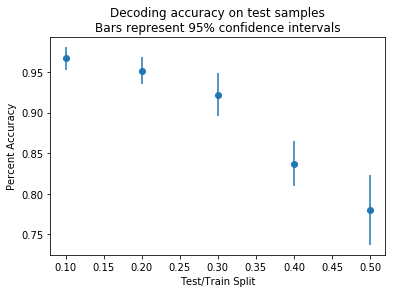

In [6]:
x = steps
y = np.mean(acc[0:len(steps)],1)
yerr = 1.96*np.std(acc[0:len(steps),:], axis=1)/np.sqrt(len(steps))
plt.errorbar(x, y, yerr=yerr, fmt='o')
plt.title('Decoding accuracy on test samples' + '\n' + 'Bars represent 95% confidence intervals')
plt.xlabel('Test/Train Split')
plt.ylabel('Percent Accuracy')